In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

## making random datapoints for example

In [3]:
pos_data_left = np.random.rand(10000, 3)
pos_df_left = pd.DataFrame(pos_data_left)
pos_df_left['time'] = np.arange(0, len(pos_df_left), 1)
pos_df_left.columns = ['x', 'y', 'z', 'second']

pos_data_right = np.random.rand(10000, 3)
pos_df_right = pd.DataFrame(pos_data_right)
pos_df_right['time'] = np.arange(0, len(pos_df_right), 1)
pos_df_right.columns = ['x', 'y', 'z', 'second']

## calculating accelation values from positional data

In [110]:
def add_acceleration(df, dt, x, y, z):
    # get velocity by difference divided by dt
    accel_df = pd.DataFrame()
    velocity_x = np.insert(np.diff(df[x]) / dt, 0, 0)
    velocity_y = np.insert(np.diff(df[y]) / dt, 0, 0) 
    velocity_z = np.insert(np.diff(df[z]) / dt, 0, 0)
    # same method for acceleration and add to df
    accel_df['accel_x'] = np.insert(np.diff(velocity_x) / dt, 0, 0)
    accel_df['accel_y'] = np.insert(np.diff(velocity_y) / dt, 0, 0)
    accel_df['accel_z'] = np.insert(np.diff(velocity_z) / dt, 0, 0)

    return accel_df

left_hand = add_acceleration(df=pos_df_left, dt=1, x='x', y='y', z='z')
right_hand = add_acceleration(df=pos_df_right, dt=1, x='x', y='y', z='z')

## calculating a variables used for movement quantification

In [111]:
def calculate_vector_magnitude(x, y, z):
    return np.sqrt(x**2 + y**2, z**2)

def calculate_hours_of_use(vector_magnitude, threshold=0.1, dt=1):
    '''
    Function to sum up all the instances where the magnitude vector is greater than a set threshold to detect activity.
    magnitude vector is an 1D-array like object containing the magnitudes per time step
    threshold is a float which must be exceeded for a signal to be counted as active
    dt is the time difference between variables.
    '''
    above_threshold = (vector_magnitude > threshold).sum()
    return above_threshold / (3600 * dt)

def calculate_use_ratio(left_hours_use, right_hours_use):
    '''
    Function to calculate a fraction between left and right hand
    close to 1 means equal use of both hands
    close to 0 means higher usage of right hand
    higher than 0 means higher usage of left hand
    '''
    return left_hours_use / right_hours_use

def calculate_magnitude_ratio(vector_magnitude_left, vector_magnitude_right):
    '''
    function which calculates in each time step which hand contributed more to the movement intensity.
    values close to 0 indiate equal usage
    values close to -7 indicate more usage of right arm
    values close to 7 indicate more usage of left arm
    '''
    ln_left = np.log(vector_magnitude_left)
    ln_right = np.log(vector_magnitude_right)
    magnitude_ratio = ln_left / ln_right
    
    return np.clip(magnitude_ratio, a_min=-7, a_max=7)

def calculate_bilateral_magnitude(vector_magnitude_left, vector_magnitude_right):
    return np.sum((vector_magnitude_left, vector_magnitude_right), axis=0)


mag_left = calculate_vector_magnitude(pos_df_left['accel_x'], pos_df_left['accel_y'], pos_df_left['accel_z'])
mag_right = calculate_vector_magnitude(pos_df_right['accel_x'], pos_df_right['accel_y'], pos_df_right['accel_z'])

left_hours_use = calculate_hours_of_use(vector_magnitude=mag_left, threshold=0.3, dt=1)
right_hours_use = calculate_hours_of_use(mag_right, threshold=0.3, dt=1)

use_ratio = calculate_use_ratio(left_hours_use=left_hours_use, right_hours_use=right_hours_use)

magnitude_ratio = calculate_magnitude_ratio(vector_magnitude_left=mag_left, vector_magnitude_right=mag_right)

bilateral_magnitude = calculate_bilateral_magnitude(mag_left, mag_right)

/var/data/python/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


## making density plots

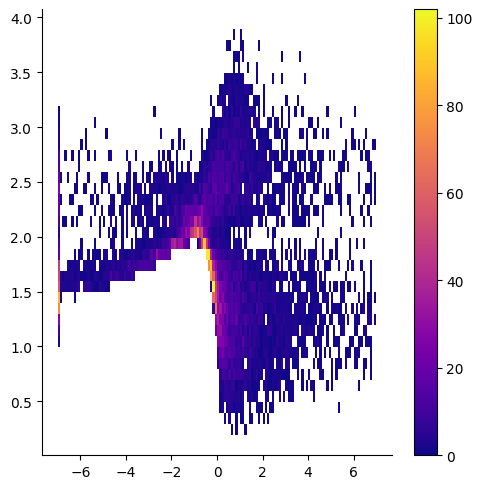

In [112]:
sns.displot(x=magnitude_ratio, y=bilateral_magnitude, binwidth=(.1, .1), cbar=True, cmap='plasma')


In [22]:
leg_df = pd.read_csv('leg_df.csv')

mag_left = calculate_vector_magnitude(leg_df['accel_x'], leg_df['accel_y'], leg_df['accel_z'])
mag_right = calculate_vector_magnitude(leg_df['accel_x'], leg_df['accel_y'], leg_df['accel_z'])

left_hours_use = calculate_hours_of_use(vector_magnitude=mag_left, threshold=0.3, dt=1/20)
right_hours_use = calculate_hours_of_use(mag_right, threshold=0.3, dt=1/20)

use_ratio = calculate_use_ratio(left_hours_use=left_hours_use, right_hours_use=right_hours_use)

magnitude_ratio = calculate_magnitude_ratio(vector_magnitude_left=mag_left, vector_magnitude_right=mag_right)

bilateral_magnitude = calculate_bilateral_magnitude(mag_left, mag_right)

#sns.displot(x=magnitude_ratio, y=bilateral_magnitude, binwidth=(0.1, 0.1), cbar=True, cmap='plasma')
print(left_hours_use)

0.017555555555555557


## test to upsample to positional data to a higher Hz -> and can then use that to differentiate and get velocity and accelation data for analysis.

In [143]:
### Reading data like we would get from an SQL query...
df = pd.read_csv('position_data.csv')
df['Timepoint'] = pd.to_datetime(df['Timepoint'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df.sort_values(by='Timepoint', inplace=True)

### Making mask to only show data from a single day and dropping any NaN vales...
mask = df['Timepoint'].dt.date == pd.to_datetime('2023-03-16', format="%Y-%m-%d").date()
df = df.loc[mask].reset_index()
df.dropna(how='any', inplace=True)
# can also interpolate the missing values, but this makes assumptions and can be wildly inaccurate
# df['l_wrist_x'].interpolate()

### Upsampling and filtering the data
from scipy.signal import resample, filtfilt, butter
def upsample_filter(x, fs=50, cutoff=0.35, order=4):
    nyquist = 0.5*fs
    resampled_data = resample(x, num=len(x) * fs)
    b, a = butter(order, cutoff/nyquist, btype='low')
    return filtfilt(b, a, resampled_data)

upsampled_df = pd.DataFrame()
upsampled_df['l_wrist_x'] = upsample_filter(df['l_wrist_x'])
upsampled_df['l_wrist_y'] = upsample_filter(df['l_wrist_y'])
upsampled_df['l_wrist_z'] = upsample_filter(df['l_wrist_z'])
upsampled_df['r_wrist_x'] = upsample_filter(df['r_wrist_x'])
upsampled_df['r_wrist_y'] = upsample_filter(df['r_wrist_y'])
upsampled_df['r_wrist_z'] = upsample_filter(df['r_wrist_z'])

/var/data/python/lib/python3.9/site-packages/pandas/core/arraylike.py:397: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [170]:
### Reading data like we would get from an SQL query...
df = pd.read_csv('03-17.csv')
df['Timepoint'] = pd.to_datetime(df['Timepoint'], format="%Y-%m-%dT%H:%M:%S.%fZ")
df.sort_values(by='Timepoint', inplace=True)

### Making mask to only show data from a single day and dropping any NaN vales...
mask = df['Timepoint'].dt.date == pd.to_datetime('2023-03-17', format="%Y-%m-%d").date()
df = df.loc[mask].reset_index(drop=True)
df.dropna(how='any', inplace=True)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2160 entries, 0 to 2174
Data columns (total 20 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   UserID        2160 non-null   object        
 1   Timepoint     2160 non-null   datetime64[ns]
 2   l_shoulder_x  2160 non-null   float64       
 3   l_shoulder_y  2160 non-null   float64       
 4   l_shoulder_z  2160 non-null   float64       
 5   l_elbow_x     2160 non-null   float64       
 6   l_elbow_y     2160 non-null   float64       
 7   l_elbow_z     2160 non-null   float64       
 8   l_wrist_x     2160 non-null   float64       
 9   l_wrist_y     2160 non-null   float64       
 10  l_wrist_z     2160 non-null   float64       
 11  r_shoulder_x  2160 non-null   float64       
 12  r_shoulder_y  2160 non-null   float64       
 13  r_shoulder_z  2160 non-null   float64       
 14  r_elbow_x     2160 non-null   float64       
 15  r_elbow_y     2160 non-null   float64 